In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from nltk import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
from fuzzywuzzy import fuzz

arabic_names = pd.read_csv('arabic_names.csv')
latest_reviews = pd.read_excel(r"google_reviews_2025-11-24_12-41-08.xlsx")
display(arabic_names.head(1), latest_reviews.sample(1))

arabic_names_list = arabic_names['english_name'].tolist()
latest_reviews_list = latest_reviews['English Review'].tolist()

# check if a review contains any Arabic name, else none
def contains_arabic_name(review):
    for name in arabic_names_list:
        if name in review:
            return name
    return ''
def fuzzy(text1, text2, threshold=80):
    return fuzz.ratio(text1, text2) >= threshold
latest_reviews['English Review'] = latest_reviews['English Review'].astype(str).fillna('')
latest_reviews['Salesman Name'] = latest_reviews['English Review'].apply(contains_arabic_name)

,english_name,arabic_name,gender,origin
0,Aali,عالي,m,Arabic


,review_date,stars,store_code,reviewer_name,review_text,English Review,Arabic Review
24,3 days ago,5,2009,Njm Gh,إيام عسل اشتريتا من عندها كثير وقسنا وزننا وطو...,)\nHoney days! We bought so much from her and ...,إيام عسل اشتريتا من عندها كثير وقسنا وزننا وطو...


In [12]:
latest_reviews['English Review']

0                                                   nan
1                                                   nan
2               )\nThe staff are respectful and polite.
3                                    )\nVery convincing
4     )\nI visited this shop today intending only to...
                            ...                        
58                                                  nan
59    )\nA nice, classy place, and the seller is ver...
60                                                  nan
61                                                  nan
62    )\nA complete spice shop, and I thank Saleh an...
Name: English Review, Length: 63, dtype: object

Sentiment Analysis Summary:

Salesman Sentiment Distribution:
Salesman_Sentiment
            39
positive    21
negative     3
Name: count, dtype: int64

Store Sentiment Distribution:
Store_Sentiment
            41
positive    19
negative     3
Name: count, dtype: int64


,English Review,Salesman_Sentiment,Store_Sentiment
0,nan,,
1,nan,,
2,)\nThe staff are respectful and polite.,positive,negative
3,)\nVery convincing,,
4,)\nI visited this shop today intending only to...,positive,positive
5,nan,,
6,")\nHonestly, it's a lovely shop and the produc...",,positive
7,")\nHonestly, it's very, very good, and the Egy...",,
8,nan,,
9,)\nRespectable people,,


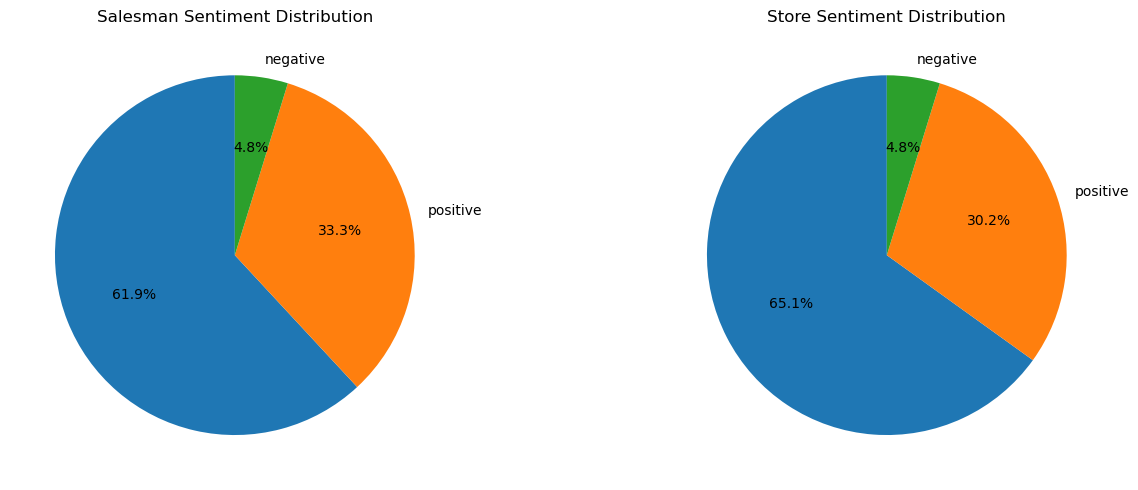

EXAMPLES OF SENTIMENT ANALYSIS

Review #1
Full Review: nan...

Salesman Context: None
Salesman Sentiment: 

Store Context: None
Store Sentiment: 

Review #2
Full Review: nan...

Salesman Context: None
Salesman Sentiment: 

Store Context: None
Store Sentiment: 

Review #3
Full Review: )
The staff are respectful and polite....

Salesman Context: )
The staff are respectful and polite
Salesman Sentiment: positive

Store Context: None
Store Sentiment: negative

Review #4
Full Review: )
Very convincing...

Salesman Context: None
Salesman Sentiment: 

Store Context: None
Store Sentiment: 

Review #5
Full Review: )
I visited this shop today intending only to buy sidr, but the staff were incredibly helpful and introduced me to other products like matcha and more. I was impressed by their professional approach; ...

Salesman Context: )
I visited this shop today intending only to buy sidr, but the staff were incredibly helpful and introduced me to other products like matcha and more
Salesman Sent

In [13]:
# Install required libraries if not already installed
# !pip install textblob vaderSentiment

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

# Initialize VADER sentiment analyzer
vader = SentimentIntensityAnalyzer()

# Keywords to identify salesman-related context
salesman_keywords = ['salesman', 'sales', 'staff', 'employee', 'service', 'representative', 
                     'helped', 'assist', 'friendly', 'professional', 'rude', 'polite',
                     'customer service', 'agent', 'worker']

# Keywords to identify store-related context
store_keywords = ['store', 'shop', 'location', 'place', 'branch', 'showroom', 'facility',
                 'clean', 'organized', 'parking', 'atmosphere', 'environment', 'products',
                 'inventory', 'selection', 'variety', 'quality', 'price', 'pricing']

def extract_context_sentences(text, keywords):
    """Extract sentences containing specific keywords"""
    if pd.isna(text) or text == '':
        return ''
    
    sentences = re.split(r'[.!?]+', str(text))
    context_sentences = []
    
    for sentence in sentences:
        sentence_lower = sentence.lower()
        if any(keyword in sentence_lower for keyword in keywords):
            context_sentences.append(sentence.strip())
    
    return ' '.join(context_sentences)

def get_sentiment(text):
    """Get sentiment score using VADER"""
    if not text or text == '':
        return 0
    
    # Get VADER scores
    scores = vader.polarity_scores(text)
    compound = scores['compound']

    return compound

sentiment_labels = {
    'positive': lambda x: x > 0.2,
    'negative': lambda x: x < 0.2,
    '': lambda x: x == 0.2
}
def label_sentiment(score):
    if score == '':
        return 'No Context'
    for label, condition in sentiment_labels.items():
        if condition(score):
            return label
    return 'neutral'


# Extract contexts
latest_reviews['Salesman_Context'] = latest_reviews['English Review'].apply(
    lambda x: extract_context_sentences(x, salesman_keywords)
)

latest_reviews['Store_Context'] = latest_reviews['English Review'].apply(
    lambda x: extract_context_sentences(x, store_keywords)
)

# Get sentiments for each context
latest_reviews['Salesman_Sentiment_score'] = latest_reviews['Salesman_Context'].apply(get_sentiment)
latest_reviews['Store_Sentiment_score'] = latest_reviews['Store_Context'].apply(get_sentiment)

# add stars score to compound score for better accuracy
latest_reviews['Salesman_Sentiment_score'] = latest_reviews['Salesman_Sentiment_score'] + (latest_reviews['stars'] - 3) * 0.1
latest_reviews['Store_Sentiment_score'] = latest_reviews['Store_Sentiment_score'] + (latest_reviews['stars'] - 3) * 0.1

# Label sentiments
latest_reviews['Salesman_Sentiment'] = latest_reviews['Salesman_Sentiment_score'].apply(label_sentiment)
latest_reviews['Store_Sentiment'] = latest_reviews['Store_Sentiment_score'].apply(label_sentiment)

# Display results
print("Sentiment Analysis Summary:")
print("\nSalesman Sentiment Distribution:")
print(latest_reviews['Salesman_Sentiment'].value_counts())
print("\nStore Sentiment Distribution:")
print(latest_reviews['Store_Sentiment'].value_counts())

# Show sample results
display(latest_reviews[['English Review', 'Salesman_Sentiment', 'Store_Sentiment']].head(10))
# Visualize sentiment distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Salesman Sentiment
salesman_counts = latest_reviews['Salesman_Sentiment'].value_counts()
if len(salesman_counts) > 0:
    axes[0].pie(salesman_counts.values, labels=salesman_counts.index, autopct='%1.1f%%', startangle=90)
    axes[0].set_title('Salesman Sentiment Distribution')
else:
    axes[0].text(0.5, 0.5, 'No Salesman Context Found', ha='center', va='center')
    axes[0].set_title('Salesman Sentiment Distribution')

# Store Sentiment
store_counts = latest_reviews['Store_Sentiment'].value_counts()
if len(store_counts) > 0:
    axes[1].pie(store_counts.values, labels=store_counts.index, autopct='%1.1f%%', startangle=90)
    axes[1].set_title('Store Sentiment Distribution')
else:
    axes[1].text(0.5, 0.5, 'No Store Context Found', ha='center', va='center')
    axes[1].set_title('Store Sentiment Distribution')

plt.tight_layout()
plt.show()

# Show detailed examples
print("="*80)
print("EXAMPLES OF SENTIMENT ANALYSIS")
print("="*80)

for idx, row in latest_reviews.head(5).iterrows():
    print(f"\n{'='*80}")
    print(f"Review #{idx + 1}")
    print(f"{'='*80}")
    print(f"Full Review: {row['English Review'][:200]}...")
    print(f"\nSalesman Context: {row['Salesman_Context'][:150] if row['Salesman_Context'] else 'None'}")
    print(f"Salesman Sentiment: {row['Salesman_Sentiment']}")
    print(f"\nStore Context: {row['Store_Context'][:150] if row['Store_Context'] else 'None'}")
    print(f"Store Sentiment: {row['Store_Sentiment']}")

# Save the updated dataframe
latest_reviews.to_excel('latest_with_sentiment.xlsx', index=False)
print(f"\n✓ Saved results to: latest_with_sentiment.xlsx")

In [14]:
latest_reviews['stars'].isna().sum()

0

In [ ]:
from datetime import datetime
date = datetime.now().date().strftime("%Y-%m-%d")
latest_reviews.to_excel(rf'User Reviews {date}.xlsx', index=False)

In [21]:

latest_reviews = pd.read_excel(fr'User Reviews {date}.xlsx')


In [22]:
from sqlalchemy import create_engine, URL, text

db_name = "knozda"
user = "postgres"
host = "192.168.1.143"
port = 5432

conn_string = URL.create(
    "postgresql+psycopg2", 
    username=user, 
    password="Python4life@", 
    host=host, 
    port=port, 
    database=db_name
)
engine = create_engine(url=conn_string)
try:
    dim_branches = pd.read_sql(
        """select "BranchID", "Branch_Name" from dim_branches""", con=engine
    )
except Exception as e:
    dim_branches = pd.read_excel(r"C:\Users\aseif\Downloads\dim_branches_locs.xlsx")

In [23]:
latest_reviews =latest_reviews.merge(
    dim_branches, left_on='store_code', right_on='BranchID', how='left'
)

In [24]:
latest_reviews.head()

,review_date,stars,store_code,reviewer_name,review_text,English Review,Arabic Review,Salesman Name,Salesman_Context,Store_Context,Salesman_Sentiment_score,Store_Sentiment_score,Salesman_Sentiment,Store_Sentiment,BranchID,Branch_Name,longtitude,latitude
0,4 hours ago,5,2168,أحمد عبدالعزيز,NaN,NaN,NaN,NaN,NaN,NaN,0.2000,0.2000,NaN,NaN,2168,جدة المروة,39.199284,21.622511
1,4 hours ago,5,2178,عيسى قاش,NaN,NaN,NaN,NaN,NaN,NaN,0.2000,0.2000,NaN,NaN,2178,خميس حي الضيافة,42.707808,18.293099
2,15 hours ago,4,2178,Fatima,الموظفين محترمين وخلوقين\n\n(Translated by Goo...,)\nThe staff are respectful and polite.,الموظفين محترمين وخلوقين\n\n(,NaN,)\nThe staff are respectful and polite,NaN,0.5588,0.1000,positive,negative,2178,خميس حي الضيافة,42.707808,18.293099
3,15 hours ago,5,2178,staloon,مقنعين جداً\n\n(Translated by Google)\nVery co...,)\nVery convincing,مقنعين جداً\n\n(,NaN,NaN,NaN,0.2000,0.2000,NaN,NaN,2178,خميس حي الضيافة,42.707808,18.293099
4,16 hours ago,5,2148,Shrooq M,زرت هذا المحل اليوم وكان قصدي فقط أشتري سدر، ل...,)\nI visited this shop today intending only to...,زرت هذا المحل اليوم وكان قصدي فقط أشتري سدر، ل...,NaN,)\nI visited this shop today intending only to...,)\nI visited this shop today intending only to...,1.1686,1.0121,positive,positive,2148,مكة الشرائع مول,39.949640,21.460131


In [25]:
_1 = latest_reviews.groupby(['Salesman Name']).agg({
    'Salesman_Sentiment': 'value_counts'
})
_2 = latest_reviews.groupby(['Branch_Name']).agg({
    'Store_Sentiment': 'value_counts'
})
_2_with_salesman = latest_reviews.groupby(['Branch_Name', 'Salesman Name']).agg({
    'Store_Sentiment': 'value_counts'
})
_1_with_store = latest_reviews.groupby(['Salesman Name', 'Branch_Name']).agg({
    'Salesman_Sentiment': 'value_counts'
})


In [26]:
_2_with_salesman

,,,Store_Sentiment
Branch_Name,Salesman Name,Store_Sentiment,
الطائف سوق النخيل,Ahmed and Mohamed,positive,1
خميس افنيو,Karim,positive,2
خميس حي الضيافة,Awad,positive,1
خميس مشيط شارع الستين,Abdullah,positive,1
سراه عبيده السوق,Saleh,positive,1
مكة العوالي,Mahmoud and Bahaa,positive,1


In [27]:
from openpyxl import Workbook
from openpyxl.styles import Font, PatternFill, Border, Side, Alignment
from openpyxl.drawing.image import Image as XLImage
from openpyxl.utils import get_column_letter
from datetime import datetime
from PIL import Image
from collections import Counter
import os

# Function to extract dominant colors from logo
def extract_color_palette(image_path, num_colors=8):
    """Extract dominant colors from an image"""
    try:
        img = Image.open(image_path)
        img = img.convert('RGB')
        img = img.resize((150, 150))  # Resize for faster processing
        
        pixels = list(img.getdata())
        
        # Filter out very light and very dark colors
        filtered_pixels = [p for p in pixels if sum(p) > 50 and sum(p) < 700]
        
        # Count color frequency
        color_counter = Counter(filtered_pixels)
        most_common = color_counter.most_common(num_colors * 3)
        
        # Convert to hex and remove duplicates
        unique_colors = []
        for color, _ in most_common:
            hex_color = '{:02X}{:02X}{:02X}'.format(*color)
            if hex_color not in unique_colors and hex_color not in ['FFFFFF', '000000']:
                unique_colors.append(hex_color)
            if len(unique_colors) >= num_colors:
                break
        
        return unique_colors
    except Exception as e:
        print(f"Could not extract colors from logo: {e}")
        return None

# Extract colors from the Artboard logo
logo_path = r'Artboard_122111724609995942.png'
extracted_colors = extract_color_palette(logo_path)

if extracted_colors and len(extracted_colors) >= 4:
    print(f"✓ Extracted {len(extracted_colors)} colors from logo:")
    for i, color in enumerate(extracted_colors[:6]):
        print(f"  Color {i+1}: #{color}")
    
    # Use extracted colors
    COLORS = {
        'primary': extracted_colors[0],      # First dominant color
        'secondary': extracted_colors[1],    # Second dominant color
        'accent1': extracted_colors[2] if len(extracted_colors) > 2 else 'F7B801',
        'accent2': extracted_colors[3] if len(extracted_colors) > 3 else '1B998B',
        'light_gray': 'F4F4F4',             # Very light gray
        'medium_gray': 'E0E0E0',            # Light gray for alternating rows
        'dark_gray': '666666',              # Dark gray for text
        'white': 'FFFFFF',
        'text_dark': '2C2C2C',              # Almost black for text
    }
else:
    # Fallback to default colors if extraction fails
    print("⚠ Using default color palette")
    COLORS = {
        'primary': 'FF6B35',      # Orange/coral primary
        'secondary': '004E89',    # Deep blue
        'accent1': 'F7B801',      # Golden yellow
        'accent2': '1B998B',      # Teal/turquoise
        'light_gray': 'F4F4F4',   # Very light gray
        'medium_gray': 'E0E0E0',  # Light gray for alternating rows
        'dark_gray': '666666',    # Dark gray for text
        'white': 'FFFFFF',
        'text_dark': '2C2C2C',    # Almost black for text
    }

def style_worksheet(ws, df, sheet_title, logo_path, color_scheme='primary'):
    """
    Apply modern, eye-comfy styling to a worksheet with logo and branded colors
    
    Parameters:
    - ws: worksheet object
    - df: pandas DataFrame to write
    - sheet_title: Title for the sheet
    - logo_path: Path to logo image
    - color_scheme: 'primary' or 'secondary' for different color themes
    """
    
    # Choose color based on scheme
    header_color = COLORS['primary'] if color_scheme == 'primary' else COLORS['secondary']
    title_bg_color = COLORS['secondary'] if color_scheme == 'primary' else COLORS['primary']
    
    # Row 1: Add logo if it exists
    current_row = 1
    if os.path.exists(logo_path):
        try:
            img = XLImage(logo_path)
            # Scale logo to fit nicely (adjust height to ~60 pixels)
            aspect_ratio = img.width / img.height
            img.height = 60
            img.width = int(60 * aspect_ratio)
            
            ws.add_image(img, 'A1')
            ws.row_dimensions[1].height = 45
            current_row = 2
        except Exception as e:
            print(f"Could not add logo: {e}")
    
    # Row 2: Title row with secondary color background
    title_row = current_row
    ws.merge_cells(f'A{title_row}:' + get_column_letter(len(df.columns)) + f'{title_row}')
    title_cell = ws[f'A{title_row}']
    title_cell.value = sheet_title
    title_cell.font = Font(name='Segoe UI', size=16, bold=True, color=COLORS['white'])
    title_cell.fill = PatternFill(start_color=title_bg_color, end_color=title_bg_color, fill_type='solid')
    title_cell.alignment = Alignment(horizontal='center', vertical='center')
    ws.row_dimensions[title_row].height = 35
    
    # Row 3+: Headers
    header_row = title_row + 1
    
    # Write headers
    for col_num, column_name in enumerate(df.columns, 1):
        cell = ws.cell(row=header_row, column=col_num)
        cell.value = str(column_name)
        cell.font = Font(name='Segoe UI', size=11, bold=True, color=COLORS['white'])
        cell.fill = PatternFill(start_color=header_color, end_color=header_color, fill_type='solid')
        cell.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
        cell.border = Border(
            bottom=Side(style='medium', color=COLORS['dark_gray'])
        )
    
    # Write data with alternating row colors
    for row_num, row_data in enumerate(df.values, header_row + 1):
        # Alternate row colors for better readability
        is_even = (row_num - header_row) % 2 == 0
        row_fill_color = COLORS['white'] if is_even else COLORS['light_gray']
        
        for col_num, value in enumerate(row_data, 1):
            cell = ws.cell(row=row_num, column=col_num)
            cell.value = value
            cell.font = Font(name='Segoe UI', size=10, color=COLORS['text_dark'])
            cell.fill = PatternFill(start_color=row_fill_color, end_color=row_fill_color, fill_type='solid')
            cell.alignment = Alignment(horizontal='left', vertical='center', wrap_text=True)
            
            # Add subtle borders
            cell.border = Border(
                left=Side(style='thin', color=COLORS['medium_gray']),
                right=Side(style='thin', color=COLORS['medium_gray']),
                bottom=Side(style='thin', color=COLORS['medium_gray'])
            )
    
    # Auto-adjust column widths
    for col_num, column_name in enumerate(df.columns, 1):
        max_length = len(str(column_name))
        for row_num in range(header_row + 1, header_row + len(df) + 1):
            cell_value = ws.cell(row=row_num, column=col_num).value
            if cell_value:
                max_length = max(max_length, len(str(cell_value)))
        
        adjusted_width = min(max_length + 3, 50)  # Cap at 50 for readability
        ws.column_dimensions[get_column_letter(col_num)].width = adjusted_width
    
    # Freeze panes at header row
    ws.freeze_panes = ws[f'A{header_row + 1}']


def create_styled_workbook(dataframes_dict, filename, logo_path):
    """
    Create a modern, beautifully styled Excel workbook with multiple sheets
    
    Parameters:
    - dataframes_dict: Dictionary with sheet names as keys and (df, color_scheme) tuples as values
    - filename: Output filename
    - logo_path: Path to logo image
    """
    wb = Workbook()
    wb.remove(wb.active)  # Remove default sheet
    
    for idx, (sheet_name, (df, color_scheme)) in enumerate(dataframes_dict.items()):
        ws = wb.create_sheet(title=sheet_name[:31])  # Excel limits sheet names to 31 chars
        style_worksheet(ws, df, sheet_name, logo_path, color_scheme)
    
    wb.save(filename)
    print(f"✓ Created beautifully styled workbook: {filename}")
    return filename


# Prepare the data for export
today = datetime.now().strftime('%Y-%m-%d')

# Create separate DataFrames for positives and negatives from the groupby results

# 1. Salesman Sentiment by Salesman Name (Positives vs Negatives)
salesman_sentiment = _1.unstack(fill_value=0).reset_index()
salesman_sentiment.columns = ['اسم البائع'] + [str(col) for col in salesman_sentiment.columns[1:]]

# 2. Store Sentiment by Branch Name (Positives vs Negatives)
store_sentiment = _2.unstack(fill_value=0).reset_index()
store_sentiment.columns = ['اسم الفرع'] + [str(col) for col in store_sentiment.columns[1:]]

# 3. Store Sentiment by Branch and Salesman
store_salesman_sentiment = _2_with_salesman.unstack(fill_value=0).reset_index()
store_salesman_sentiment.columns = ['اسم الفرع', 'اسم البائع'] + [str(col) for col in store_salesman_sentiment.columns[2:]]

# 4. Salesman Sentiment by Salesman and Branch
salesman_store_sentiment = _1_with_store.unstack(fill_value=0).reset_index()
salesman_store_sentiment.columns = ['اسم البائع', 'اسم الفرع'] + [str(col) for col in salesman_store_sentiment.columns[2:]]

# 5. Full reviews data with key columns
reviews_export = latest_reviews[[
    'stars', 'Branch_Name', 'Salesman Name', 
    'English Review', 'Salesman_Sentiment', 'Store_Sentiment',
    'Salesman_Context', 'Store_Context'
]].copy()

# Rename columns to Arabic
reviews_export.columns = [
    'التقييم', 'الفرع', 'اسم البائع',
    'المراجعة', 'مشاعر البائع', 'مشاعر المتجر',
    'سياق البائع', 'سياق المتجر'
]

# Create the styled workbook with Arabic sheet name
arabic_sheet_name = f'شيت المدح والذم - {today}'

workbook_data = {
    arabic_sheet_name: (salesman_sentiment, 'primary'),
    '📊 أداء البائعين': (salesman_sentiment, 'primary'),
    '🏪 أداء الفروع': (store_sentiment, 'secondary'),
    '👥 الفرع × البائع': (store_salesman_sentiment, 'primary'),
    '🎯 البائع × الفرع': (salesman_store_sentiment, 'secondary'),
    '📝 جميع المراجعات': (reviews_export, 'primary'),
}

output_file = f'تقرير_تحليل_المشاعر_{today}.xlsx'
create_styled_workbook(workbook_data, output_file, logo_path)

print(f"\n{'='*60}")
print(f"📊 ملخص التقرير / REPORT SUMMARY")
print(f"{'='*60}")
print(f"إجمالي المراجعات / Total Reviews: {len(latest_reviews)}")
print(f"البائعون المحللون / Salesmen Analyzed: {len(salesman_sentiment)}")
print(f"الفروع المحللة / Branches Analyzed: {len(store_sentiment)}")
print(f"\n✓ تم حفظ التقرير / Report saved as: {output_file}")
print(f"\n🎨 لوحة الألوان المستخدمة / Color Palette Used:")
print(f"  Primary: #{COLORS['primary']}")
print(f"  Secondary: #{COLORS['secondary']}")
print(f"  Accent 1: #{COLORS['accent1']}")
print(f"  Accent 2: #{COLORS['accent2']}")
print(f"{'='*60}")

✓ Extracted 8 colors from logo:
  Color 1: #2E9849
  Color 2: #279443
  Color 3: #2D9B4A
  Color 4: #289544
  Color 5: #BEDFC6
  Color 6: #B6DBBF
✓ Created beautifully styled workbook: تقرير_تحليل_المشاعر_2025-11-24.xlsx

📊 ملخص التقرير / REPORT SUMMARY
إجمالي المراجعات / Total Reviews: 63
البائعون المحللون / Salesmen Analyzed: 6
الفروع المحللة / Branches Analyzed: 16

✓ تم حفظ التقرير / Report saved as: تقرير_تحليل_المشاعر_2025-11-24.xlsx

🎨 لوحة الألوان المستخدمة / Color Palette Used:
  Primary: #2E9849
  Secondary: #279443
  Accent 1: #2D9B4A
  Accent 2: #289544
